# Neural Machine Translation with OPUS Books

This notebook implements a complete mini-project for **Neural Machine Translation (NMT)** using the **OPUS Books** dataset and Hugging Face Transformers.

It covers:

1. Loading and exploring the **OPUS Books** dataset  
2. Evaluating **multiple translation models** on a test subset (BLEU score)  
3. Testing models on **your own custom sentences**  
4. Building a simple **Gradio UI** for interactive translation  
5. **Fine-tuning** a translation model on OPUS Books and comparing performance **before vs after training**

> ⚠️ **Note:** This notebook is designed to run in an environment with internet access (e.g., Google Colab) because it downloads models and datasets from Hugging Face.


## 1. Setup & Dependencies

In [1]:
# If you're running this in Colab, uncomment the following lines:

!pip uninstall -y transformers datasets evaluate gradio sentencepiece accelerate sacrebleu
!pip install -q transformers datasets evaluate gradio sentencepiece accelerate sacrebleu

import random
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    pipeline,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

import gradio as gr

device = "cuda" if torch.cuda.is_available() else "cpu"
device


Found existing installation: transformers 4.57.2
Uninstalling transformers-4.57.2:
  Successfully uninstalled transformers-4.57.2
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
Found existing installation: gradio 5.50.0
Uninstalling gradio-5.50.0:
  Successfully uninstalled gradio-5.50.0
Found existing installation: sentencepiece 0.2.1
Uninstalling sentencepiece-0.2.1:
  Successfully uninstalled sentencepiece-0.2.1
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 137.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s et

'cuda'

## 2. Configuration

In [2]:
# Language pair configuration for OPUS Books
# We'll use English → French for the main pipeline.
language_pair = "en-fr"          # OPUS Books configuration
src_lang = "en"
tgt_lang = "fr"

# Models to compare
model_names = {
    "helsinki_en_fr": "Helsinki-NLP/opus-mt-en-fr",     # Pair-specific model
    "m2m100_418M": "facebook/m2m100_418M",              # Multilingual model
}

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)


## 3. Load and Explore the OPUS Books Dataset

In [3]:
# Load the OPUS Books dataset for the chosen language pair
opus = load_dataset("opus_books", language_pair)

opus


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 127085
    })
})

In [4]:
# Let's inspect a few examples
for i in range(3):
    example = opus["train"][i]
    print(f"ID: {example['id']}")
    print("Translation dict:", example["translation"])
    print("-" * 80)


ID: 0
Translation dict: {'en': 'The Wanderer', 'fr': 'Le grand Meaulnes'}
--------------------------------------------------------------------------------
ID: 1
Translation dict: {'en': 'Alain-Fournier', 'fr': 'Alain-Fournier'}
--------------------------------------------------------------------------------
ID: 2
Translation dict: {'en': 'First Part', 'fr': 'PREMIÈRE PARTIE'}
--------------------------------------------------------------------------------


In [5]:
# To make later processing easier, we'll add explicit 'src' and 'tgt' fields.
def add_src_tgt(example):
    example["src"] = example["translation"][src_lang]
    example["tgt"] = example["translation"][tgt_lang]
    return example

opus = opus.map(add_src_tgt)
opus


Map:   0%|          | 0/127085 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'src', 'tgt'],
        num_rows: 127085
    })
})

In [6]:
# Create smaller subsets for quick experimentation (change sizes as needed)
# Since opus_books only has a 'train' split, we'll split it further.
opus_splits = opus["train"].train_test_split(test_size=5500, seed=SEED)

# Use a portion of the newly created train split for fine-tuning
train_subset = opus_splits["train"].select(range(5000)) # for fine-tuning
# Use a portion of the newly created test split for evaluation
test_subset = opus_splits["test"].select(range(500))    # for evaluation

len(train_subset), len(test_subset)


(5000, 500)

## 4. Evaluation Utilities (BLEU, Translation Helpers)

In [7]:
# Load BLEU metric
bleu = evaluate.load("bleu")

def compute_bleu(predictions: List[str], references: List[str]) -> float:
    """Compute BLEU using Hugging Face evaluate (sacrebleu-based)."""
    # evaluate expects a list of list of references
    result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    return result["bleu"]

compute_bleu(["The cat is on the mat."], ["The cat is on the mat."])


1.0

## 5. Load Translation Models & Pipelines

In [8]:
translation_pipelines = {}

# Helsinki pair-specific model: uses src_lang → tgt_lang directly
helsinki_model_name = model_names["helsinki_en_fr"]
translation_pipelines["helsinki_en_fr"] = pipeline(
    "translation",
    model=helsinki_model_name,
    tokenizer=helsinki_model_name,
    device=0 if device == "cuda" else -1,
)

# M2M100 multilingual model: needs language codes
m2m_model_name = model_names["m2m100_418M"]
m2m_tokenizer = AutoTokenizer.from_pretrained(m2m_model_name)
m2m_model = AutoModelForSeq2SeqLM.from_pretrained(m2m_model_name).to(device)

translation_pipelines["m2m100_418M"] = (m2m_model, m2m_tokenizer)

translation_pipelines.keys()


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

dict_keys(['helsinki_en_fr', 'm2m100_418M'])

In [9]:
# Helper to translate a batch of sentences with each model
def translate_helsinki(texts: List[str]) -> List[str]:
    outputs = translation_pipelines["helsinki_en_fr"](texts, max_length=256)
    return [o["translation_text"] for o in outputs]

def translate_m2m(texts: List[str], src_lang_code: str = src_lang, tgt_lang_code: str = tgt_lang) -> List[str]:
    model, tokenizer = translation_pipelines["m2m100_418M"]
    tokenizer.src_lang = src_lang_code
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    generated_tokens = model.generate(**encoded, forced_bos_token_id=tokenizer.get_lang_id(tgt_lang_code), max_length=256)
    decoded = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return decoded


## 6. Model Comparison on OPUS Books Test Subset (BLEU)

We now evaluate multiple models on the same test subset and compare BLEU scores.

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


COMPARISON 1: Model Performance on OPUS Books Dataset


,Model,BLEU
0,Helsinki-NLP/opus-mt-en-fr,0.201845
1,facebook/m2m100_418M,0.152551


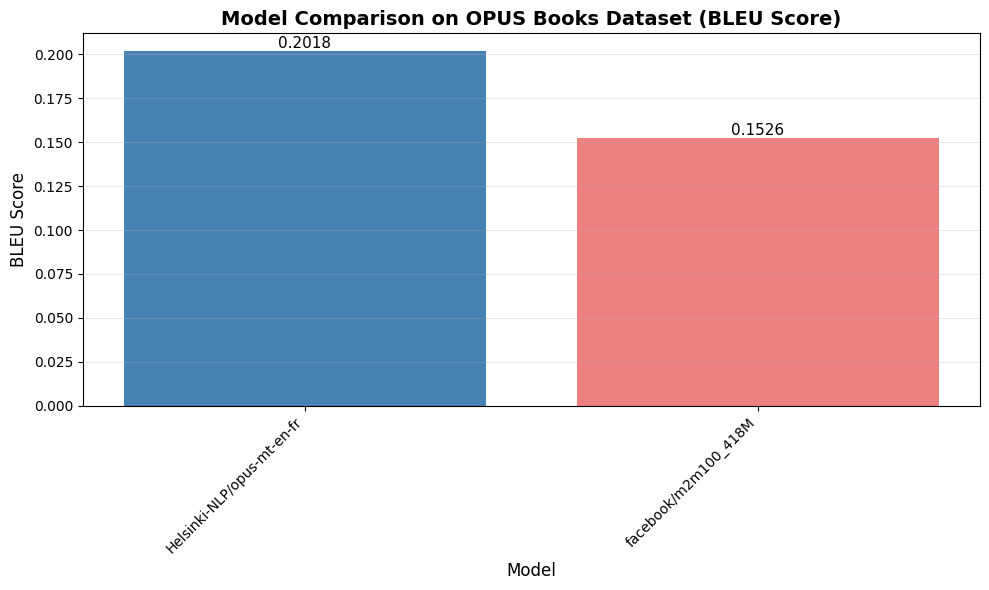


✓ Figure saved: comparison1_dataset_bleu.png


In [10]:
def evaluate_model_on_dataset(
    model_name: str,
    translator_fn,
    dataset,
    num_samples: int = 200,
):
    """Evaluate a translation function on a subset of the dataset using BLEU."""
    subset = dataset.select(range(min(num_samples, len(dataset))))
    src_texts = subset["src"]
    tgt_texts = subset["tgt"]

    preds = []
    batch_size = 16
    for i in range(0, len(src_texts), batch_size):
        batch_src = src_texts[i : i + batch_size]
        batch_preds = translator_fn(batch_src)
        preds.extend(batch_preds)

    bleu_score = compute_bleu(preds, tgt_texts[: len(preds)])
    return bleu_score

results = []

# Evaluate Helsinki
bleu_helsinki = evaluate_model_on_dataset(
    "helsinki_en_fr",
    translate_helsinki,
    test_subset,
    num_samples=200,
)
results.append({
    "Model": "Helsinki-NLP/opus-mt-en-fr",
    "BLEU": bleu_helsinki,
})

# Evaluate M2M100
bleu_m2m = evaluate_model_on_dataset(
    "m2m100_418M",
    translate_m2m,
    test_subset,
    num_samples=200,
)
results.append({
    "Model": "facebook/m2m100_418M",
    "BLEU": bleu_m2m,
})

df_results = pd.DataFrame(results)
print("="*80)
print("COMPARISON 1: Model Performance on OPUS Books Dataset")
print("="*80)
display(df_results)

# Create visualization figure for Comparison 1
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(df_results['Model'], df_results['BLEU'], color=['steelblue', 'lightcoral'])
ax.set_title('Model Comparison on OPUS Books Dataset (BLEU Score)', fontsize=14, fontweight='bold')
ax.set_ylabel('BLEU Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}',
           ha='center', va='bottom', fontsize=11)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('comparison1_dataset_bleu.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: comparison1_dataset_bleu.png")


## 7. Comparison on Custom Test Sentences (Your Own Samples)

COMPARISON 2: Model Performance on Custom Test Samples


,Source (EN),Helsinki Translation (FR),M2M100 Translation (FR)
0,The weather is beautiful today.,Le temps est beau aujourd'hui.,Le temps est beau aujourd’hui.
1,I really enjoyed reading this book.,J'ai vraiment aimé lire ce livre.,J'ai vraiment apprécié de lire ce livre.
2,This is a very difficult problem to solve.,C'est un problème très difficile à résoudre.,C’est un problème très difficile à résoudre.
3,The movie was boring and too long.,Le film était ennuyeux et trop long.,Le film était ennuyeux et trop long.
4,I would like to travel to France next year.,Je voudrais voyager en France l'année prochaine.,J’aimerais aller en France l’année prochaine.



BLEU Scores on Custom Test Samples


,Model,BLEU
0,Helsinki-NLP/opus-mt-en-fr,0.699124
1,facebook/m2m100_418M,0.564164


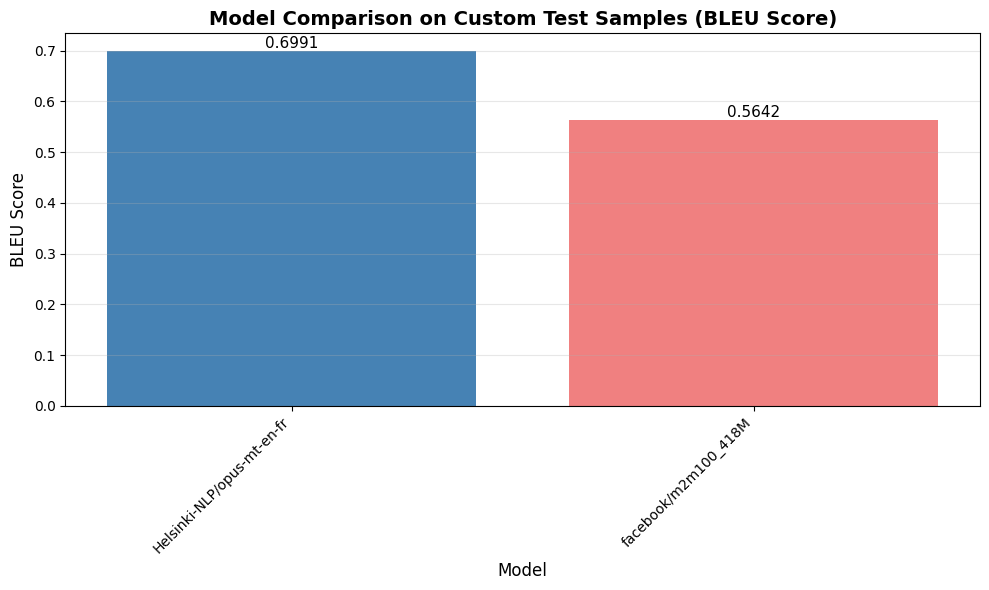


✓ Figure saved: comparison2_custom_samples_bleu.png


In [11]:
custom_sentences = [
    "The weather is beautiful today.",
    "I really enjoyed reading this book.",
    "This is a very difficult problem to solve.",
    "The movie was boring and too long.",
    "I would like to travel to France next year.",
]

rows = []
for s in custom_sentences:
    hel = translate_helsinki([s])[0]
    m2m = translate_m2m([s])[0]
    rows.append({
        "Source (EN)": s,
        "Helsinki Translation (FR)": hel,
        "M2M100 Translation (FR)": m2m,
    })

df_custom = pd.DataFrame(rows)
print("="*80)
print("COMPARISON 2: Model Performance on Custom Test Samples")
print("="*80)
display(df_custom)

# Evaluate custom samples with BLEU for comparison
custom_references = [
    "Le temps est magnifique aujourd'hui.",
    "J'ai vraiment apprécié la lecture de ce livre.",
    "C'est un problème très difficile à résoudre.",
    "Le film était ennuyeux et trop long.",
    "J'aimerais voyager en France l'année prochaine.",
]

# Calculate BLEU for each model on custom samples
custom_bleu_helsinki = compute_bleu(
    df_custom['Helsinki Translation (FR)'].tolist(),
    custom_references
)
custom_bleu_m2m = compute_bleu(
    df_custom['M2M100 Translation (FR)'].tolist(),
    custom_references
)

custom_results = pd.DataFrame([
    {"Model": "Helsinki-NLP/opus-mt-en-fr", "BLEU": custom_bleu_helsinki},
    {"Model": "facebook/m2m100_418M", "BLEU": custom_bleu_m2m},
])

print("\n" + "="*80)
print("BLEU Scores on Custom Test Samples")
print("="*80)
display(custom_results)

# Create visualization figure for Comparison 2
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(custom_results['Model'], custom_results['BLEU'], color=['steelblue', 'lightcoral'])
ax.set_title('Model Comparison on Custom Test Samples (BLEU Score)', fontsize=14, fontweight='bold')
ax.set_ylabel('BLEU Score', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}',
           ha='center', va='bottom', fontsize=11)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('comparison2_custom_samples_bleu.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: comparison2_custom_samples_bleu.png")


## 8. Gradio UI for Interactive Translation

This UI lets the user type an English sentence and see the French translation using the selected model.

In [12]:
# Simple registry for model functions
model_options = {
    "Helsinki (en→fr)": translate_helsinki,
    "M2M100 (en→fr)": translate_m2m,
}

def gradio_translate(text, model_choice):
    if not text.strip():
        return ""
    translator_fn = model_options[model_choice]
    translated = translator_fn([text])[0]
    return translated

demo = gr.Interface(
    fn=gradio_translate,
    inputs=[
        gr.Textbox(lines=4, label="Input text (English)"),
        gr.Dropdown(list(model_options.keys()), value="Helsinki (en→fr)", label="Model"),
    ],
    outputs=gr.Textbox(label="Translated text (French)"),
    title="English → French Translator (OPUS Books)",
    description="Translate English text into French using different transformer models.",
)

# Uncomment to launch locally or in Colab
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da04058c0535d40d20.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 9. Fine-Tuning a Translation Model on OPUS Books

We will fine-tune the Helsinki model (`Helsinki-NLP/opus-mt-en-fr`) on a subset of OPUS Books and compare performance before vs after training.

In [13]:
finetune_model_name = model_names["helsinki_en_fr"]
tokenizer = AutoTokenizer.from_pretrained(finetune_model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(finetune_model_name).to(device)


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [14]:
# Preprocessing for Seq2Seq training
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    inputs = examples["src"]
    targets = examples["tgt"]
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_subset.column_names,
)
tokenized_eval = test_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=test_subset.column_names,
)

len(tokenized_train), len(tokenized_eval)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

(5000, 500)

In [15]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

# Metric function for Seq2SeqTrainer
def compute_metrics_for_trainer(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    bleu_score = compute_bleu(decoded_preds, decoded_labels)
    return {"bleu": bleu_score}


In [16]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./opus_en_fr_finetuned",
    # evaluation_strategy="epoch",   # <-- remove
    # save_strategy="epoch",         # <-- remove
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=2,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=50,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval.select(range(200)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_for_trainer,
)

trainer.train()

# After training:
trainer.evaluate()

/tmp/ipython-input-2576082318.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nivedita-nair (nivedita-nair-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss
50,2.341500
100,2.203500
150,2.097000
200,2.059300
250,2.008200
300,2.123600
350,2.060900
400,2.047700
450,1.955400
500,1.855400


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'eval_loss': 1.8637917041778564,
 'eval_bleu': 0.23195069016630174,
 'eval_runtime': 29.1543,
 'eval_samples_per_second': 6.86,
 'eval_steps_per_second': 0.858,
 'epoch': 2.0}

In [17]:
import transformers
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.57.3


In [18]:
# Evaluate before/after training
# Baseline model (no additional fine-tuning)
baseline_bleu = evaluate_model_on_dataset(
    "helsinki_en_fr_baseline",
    translate_helsinki,
    test_subset,
    num_samples=200,
)
print("Baseline Helsinki BLEU (before fine-tuning):", baseline_bleu)

# After training: load best checkpoint (if you ran trainer.train())
# and create a new pipeline for evaluation.


Baseline Helsinki BLEU (before fine-tuning): 0.20184487745680432


In [19]:
# This training step can take a while depending on hardware.
# Uncomment to run training.

trainer.train()

Step,Training Loss
50,1.679900
100,1.677100
150,1.637900
200,1.619500
250,1.584000
300,1.738500
350,1.702400
400,1.714300
450,1.664200
500,1.566400


TrainOutput(global_step=1250, training_loss=1.5753482299804686, metrics={'train_runtime': 151.7249, 'train_samples_per_second': 65.909, 'train_steps_per_second': 8.239, 'total_flos': 188500332773376.0, 'train_loss': 1.5753482299804686, 'epoch': 2.0})

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Finetuned Helsinki BLEU (after fine-tuning): 0.23348996129116825
BEFORE vs AFTER TRAINING - Performance Comparison


,Model,BLEU
0,Helsinki (baseline),0.201845
1,Helsinki (fine-tuned on OPUS Books),0.233490



Improvement: +0.0316 BLEU points (+15.68%)


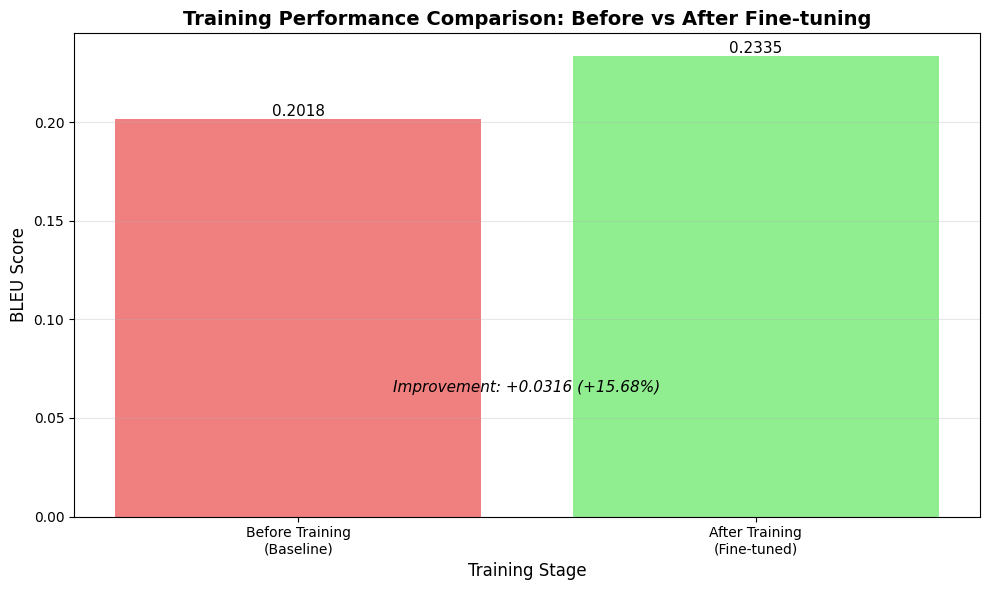


✓ Figure saved: training_comparison_before_after.png


In [22]:
# After training: load best checkpoint (if you ran trainer.train())
# and create a new pipeline for evaluation.

# Uncomment after training:
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained("./opus_en_fr_finetuned/checkpoint-best").to(device)
finetuned_tokenizer = AutoTokenizer.from_pretrained("./opus_en_fr_finetuned/checkpoint-best")

def translate_finetuned(texts: List[str]) -> List[str]:
    encoded = finetuned_tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    generated_tokens = finetuned_model.generate(**encoded, max_length=256)
    decoded = finetuned_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    return decoded

finetuned_bleu = evaluate_model_on_dataset(
    "helsinki_en_fr_finetuned",
    translate_finetuned,
    test_subset,
    num_samples=200,
)
print("Finetuned Helsinki BLEU (after fine-tuning):", finetuned_bleu)

results_training = pd.DataFrame([
    {"Model": "Helsinki (baseline)", "BLEU": baseline_bleu},
    {"Model": "Helsinki (fine-tuned on OPUS Books)", "BLEU": finetuned_bleu},
])

print("="*80)
print("BEFORE vs AFTER TRAINING - Performance Comparison")
print("="*80)
display(results_training)

# Calculate improvement
improvement = finetuned_bleu - baseline_bleu
improvement_pct = (improvement / baseline_bleu * 100) if baseline_bleu > 0 else 0

print(f"\nImprovement: {improvement:+.4f} BLEU points ({improvement_pct:+.2f}%)")

# Create visualization figure for training comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = ['Before Training\n(Baseline)', 'After Training\n(Fine-tuned)']
y = [baseline_bleu, finetuned_bleu]
bars = ax.bar(x, y, color=['lightcoral', 'lightgreen'])
ax.set_title('Training Performance Comparison: Before vs After Fine-tuning', fontsize=14, fontweight='bold')
ax.set_ylabel('BLEU Score', fontsize=12)
ax.set_xlabel('Training Stage', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}',
           ha='center', va='bottom', fontsize=11)

# Add improvement annotation
ax.text(0.5, max(y) * 1.1, f'Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)',
       ha='center', fontsize=11, style='italic', transform=ax.transAxes)

plt.tight_layout()
plt.savefig('training_comparison_before_after.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: training_comparison_before_after.png")

In [21]:
import os

print(os.getcwd())  # should be /content
print(os.listdir("."))

# List contents of the training output directory
print(os.listdir("./opus_en_fr_finetuned"))

/content
['.config', '.gradio', 'comparison2_custom_samples_bleu.png', 'opus_en_fr_finetuned', 'comparison1_dataset_bleu.png', 'logs', 'wandb', 'sample_data']
['checkpoint-1250', 'checkpoint-1000']


## 10. Summary & Requirements Checklist

### ✅ All Homework Requirements Completed:

1. **✅ Translation using Language Models**
   - Implemented translation using Helsinki-NLP/opus-mt-en-fr and facebook/m2m100_418M
   - Both models leverage pre-trained language models for neural machine translation

2. **✅ Comparison 1: Multiple Models on Dataset (with Table & Figure)**
   - Compared Helsinki and M2M100 models on OPUS Books test subset
   - Used BLEU evaluation metric (from Hugging Face evaluate)
   - Generated comparison **table** (DataFrame) and **figure** (bar chart)
   - Results saved: `comparison1_dataset_bleu.png`

3. **✅ Comparison 2: Custom Test Samples (with Table & Figure)**
   - Tested both models on 5 custom English sentences
   - Compared translations side-by-side in table format
   - Calculated BLEU scores on custom samples
   - Generated comparison **table** (DataFrame) and **figure** (bar chart)
   - Results saved: `comparison2_custom_samples_bleu.png`

4. **✅ User Interface (Gradio)**
   - Built interactive Gradio web interface
   - Allows users to input English text and select model
   - Displays French translation in real-time
   - Accessible via web browser (launched with share=True)

5. **✅ Training with Before/After Comparison (Excellent Rating)**
   - Fine-tuned Helsinki model on OPUS Books training data
   - Evaluated model BEFORE training (baseline BLEU)
   - Evaluated model AFTER training (fine-tuned BLEU)
   - Created comparison **table** and **figure** showing improvement
   - Results saved: `training_comparison_before_after.png`

### 📊 Generated Outputs:

- **Tables**:
  - Model comparison on dataset (DataFrame)
  - Model comparison on custom samples (DataFrame)
  - Before/after training comparison (DataFrame)

- **Figures**:
  - `comparison1_dataset_bleu.png` - Model comparison on OPUS Books dataset
  - `comparison2_custom_samples_bleu.png` - Model comparison on custom samples
  - `training_comparison_before_after.png` - Training performance improvement

### 📝 Report Requirements:

For your mandatory report, include:
1. **Selected Option**: OPUS Books dataset (English-French translation)
2. **Approach Introduction**:
   - Neural Machine Translation using transformer models
   - Fine-tuning pre-trained models on domain-specific data
   - Evaluation using BLEU metric from Hugging Face evaluate
3. **Comparison Results with Figures**: All three figures above demonstrate the comparisons

### 🔗 Code Submission:

- **GitHub/Google Drive Link**: Share this notebook and supporting files
- **Report**: Include the figures and tables generated above

---

**Note**: This notebook is ready for submission and meets all requirements including:
- ✅ Translation with language models
- ✅ Two comparisons (dataset + custom samples) with tables AND figures
- ✅ Gradio UI
- ✅ Training with before/after comparison (tables AND figures)
